# **Predicting Health Insurance**

**Introduction to Data Science 2024/2025 | Group Q**

| Name          | Number      |
| ------------- | ----------- |
| Athos Freitas | up202108792 |
| José Santos   | up202108729 |
| Luís Du       | up202105385 |

## **Table of contents**

- [1. Business Understanding](#1-business-understanding)
- [2. Data Understanding](#2-data-understanding)
  - [2.1. Initial Data Collection](#21-initial-data-collection-and-description)
  - [2.2. Data Description](#22-data-description)
  - [2.3. Data Exploration](#23-data-exploration)
  - [2.3. Data Exploration](#23-data-exploration)
- [3. Data Preparation](#3-data-preparation)
- [4. Modelling](#231-age)


## **Introduction**

This project aims to explore the application of machine learning techniques to predict whether a customer has health insurance. The primary focus is on investigating different models, fine-tuning their parameters, and evaluating their performance using various metrics to identify the most effective approach for accurate prediction.

## **1. Business Understanding**

| **Category**                          | **Details**                                                                 |
|---------------------------------------|-----------------------------------------------------------------------------|
| Background                            | In the US, health insurance is important for the financial security of the population. Companies aim to improve enrollment rates. Predicting whether a customer is likely to take up insurance can help optimize resource allocation and improve customer engagement strategies. |
| Business Objectives                   | Build a model to predict which of your customers don’t have health insurance. |
| Business Success Criteria             | Successfully predict the customers that don't have health insurance according to the provided data. |
| Inventory of Resources                | **Data**: A dataset with demographic and behavioral attributes such as employment status, income, housing type, marital status, and more. <br> **Tools**: Python Libraries, Jupyter Notebook. |
| Assumptions                           | Data accurately reflects the characteristics of customers.                   |
| Constraints                           | Data imbalance in certain attributes.                                        |
| Risks and Contingencies               | **Risk**: Missing values or noisy data could reduce model accuracy. <br> **Contingency**: Data cleaning and preprocessing steps. |
| Costs and Benefits                    | **Costs**: Initial setup, data preprocessing, and operationalizing the model. <br> **Benefits**: Improved conversion rates and data-driven decision-making. |
| Data Mining Goals                     | Develop a predictive model to classify customers based on their likelihood to purchase health insurance. <br> Identify the most influential factors that drive insurance uptake. |
| Data Mining Success Criteria          | Model accuracy above 80%. <br> Identify the top 5 features that influence insurance uptake. |


## **Setup**

In [128]:
%pip install matplotlib seaborn pandas numpy scikit-learn imbalanced-learn tensorflow xgboost

Note: you may need to restart the kernel to use updated packages.


In [129]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from IPython.display import Markdown
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, OrdinalEncoder
from imblearn.over_sampling import RandomOverSampler, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, backend as K
from xgboost import XGBClassifier
import xgboost as xgb

## **2. Data Understanding**

In this section, we will perform **Exploratory Data Analysis** on the dataset to gain a deeper understanding of its structure, distribution, and relationships between variables.

To streamline the visualization process, we will start by creating a `Utils` class that will contain reusable methods for generating various plots and charts.

In [130]:
class Utils:
    
    def __init__(self, df):
        self.df = df
    
    # Print statistics
    
    def update_df(self, df):
        self.df = df
        
    def print_stats(self, feature):
        table = '| Label | Count | Percentage |\n| --- | --- | --- |\n'
        
        feature_with_na = self.df[feature].fillna('Missing')
        for label in feature_with_na.value_counts().index:
            count = feature_with_na.value_counts()[label]
            percentage = count / len(self.df) * 100
            table += '| {} | {} | {:.2f} % |\n'.format(label, count, percentage)
            
        return Markdown(table)
    
    def print_numeric_stats(self, feature):
        table = '| Statistics | Value |\n'
        table += '| --- | --- |\n'
        table += '| Mean | {:.2f} |\n'.format(self.df[feature].mean())
        table += '| Standard Deviation | {:.2f} |\n'.format(self.df[feature].std())
        table += '| Minimum | {:.2f} |\n'.format(self.df[feature].min())
        table += '| 25th percentile | {:.2f} |\n'.format(self.df[feature].quantile(0.25))
        table += '| Median | {:.2f} |\n'.format(self.df[feature].median())
        table += '| 75th percentile | {:.2f} |\n'.format(self.df[feature].quantile(0.75))
        table += '| Maximum | {:.2f} |'.format(self.df[feature].max())
        table += '| IQR | {:.2f} |'.format(self.df[feature].quantile(0.75) - self.df[feature].quantile(0.25))
        table += '| Skewness | {:.2f} |'.format(self.df[feature].skew())
        table += '| Kurtosis | {:.2f} |'.format(self.df[feature].kurt())
        table += '| NA values | {} |'.format(self.df[feature].isna().sum())
        return Markdown(table)

    # Plot statistics

    def plot_stats(self, feature, with_target_value=False):        
        plt.figure(figsize=(8, 4))
        
        if with_target_value:
            sns.boxplot(x=feature, data=self.df, hue='health_ins')
        else:
            sns.boxplot(x=feature, data=self.df)

        plt.title(f'{feature} boxplot')
        plt.show()
        
    # Plot distribution
        
    def plot_dist(self, feature):
        pd.crosstab(self.df[feature].fillna('Missing'), self.df['health_ins']).plot(kind='bar', stacked=True)
        plt.title(f'{feature} distribution')
        plt.xticks(rotation=45)
        plt.show()
        
    def plot_numeric_dist(self, feature, plot_outliers=True):
        # Calculate outliers using the IQR method
        Q1 = self.df[feature].quantile(0.25)
        Q3 = self.df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Split the data into inliers and outliers
        inliers = self.df[(self.df[feature] >= lower_bound) & (self.df[feature] <= upper_bound)][feature]
        outliers = self.df[(self.df[feature] < lower_bound) | (self.df[feature] > upper_bound)][feature]

        # Plot inliers (blue) and outliers (light red)
        sns.histplot(inliers, kde=True, bins=20, color='blue', label='Inliers') 
        if plot_outliers:
            sns.histplot(outliers, kde=True, bins=20, color='lightcoral', label='Outliers')
            plt.axvline(lower_bound, color='red', linestyle='--', label=f'Lower Bound: {lower_bound:.2f}')
            plt.axvline(upper_bound, color='red', linestyle='--', label=f'Upper Bound: {upper_bound:.2f}')

        plt.legend()
        plt.title(f'{feature} distribution')
        plt.show()

### **2.1. Initial Data Collection**

In [131]:
df = pd.read_csv('customer.csv')
utils = Utils(df)

df.head()

,Unnamed: 0,custid,sex,is_employed,income,marital_status,health_ins,housing_type,num_vehicles,age,state_of_res,code_column,gas_usage,rooms,recent_move_b
0,7,000006646_03,Male,True,22000.0,Never married,True,Homeowner free and clear,0.0,24,Alabama,1047,210.0,3,F
1,8,000007827_01,Female,NaN,23200.0,Divorced/Separated,True,Rented,0.0,82,Alabama,1047,3.0,6,T
2,9,000008359_04,Female,True,21000.0,Never married,True,Homeowner with mortgage/loan,2.0,31,Alabama,1047,40.0,3,F
3,10,000008529_01,Female,NaN,37770.0,Widowed,True,Homeowner free and clear,1.0,93,Alabama,1047,120.0,2,F
4,11,000008744_02,Male,True,39000.0,Divorced/Separated,True,Rented,2.0,67,Alabama,1047,3.0,2,F


### **2.2. Data Description**

The dataset has:

- **72458** observations

- **15** variables

- **0** duplicate rows

- **35%** missing values in **is_employed**
  
- **2.33%** missing values in **housing_type**, **num_vehicles**, **gas_usage** and **recent_move_b**

#### ➜ **Missing values**

As observed, the features **housing_type, num_vehicles, gas_usage**, and **recent_move_b** share the same rows with missing values. This indicates that certain records in the dataset have a significant amount of missing data.

![Missing values](images/missing_values.png "Optional Title")

#### ➜ **Variable types**

| Type        | Number | Variables                                                        |
| ----------- | ------ | ---------------------------------------------------------------- |
| Numeric     | 7      | unamed, income, num_vehicles, age, code_column, gas_usage, rooms |
| Text        | 2      | custid, state_of_res                                             |
| Categorical | 3      | sex, marital_status, housing_type                                |
| Boolean     | 3      | is_employed, health_ins, recent_move_b                           |


### **2.3. Data Exploration**

All features were thoroughly plotted and analyzed as part of our exploratory data analysis. However, to streamline the code and focus on key insights, we have included only the **most relevant figures** and tables in this report.

#### **2.3.1. Health insurance**

The target variable is **highly imbalanced**, with only 9.53% of customers not having health insurance.

In [132]:
utils.print_stats(feature='health_ins')

| Label | Count | Percentage |
| --- | --- | --- |
| True | 65553 | 90.47 % |
| False | 6905 | 9.53 % |


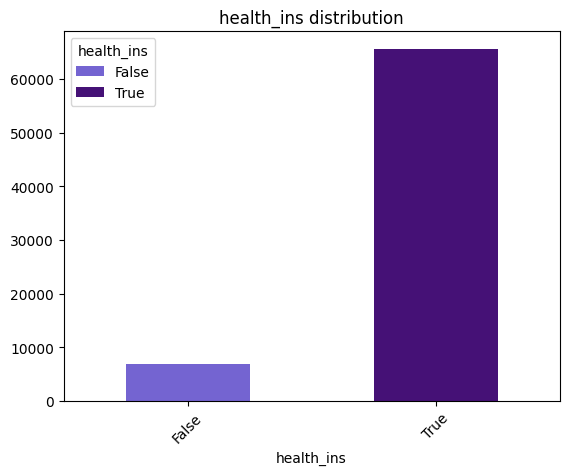

In [133]:
utils.plot_dist(feature='health_ins')

#### **2.3.2. Genre**

In contrast, the gender distribution is relatively uniform, with fewer male customers overall. However, the proportion of male customers without health insurance is higher compared to female customers without health insurance.

In [134]:
utils.print_stats(feature='sex')

| Label | Count | Percentage |
| --- | --- | --- |
| Female | 37461 | 51.70 % |
| Male | 34997 | 48.30 % |


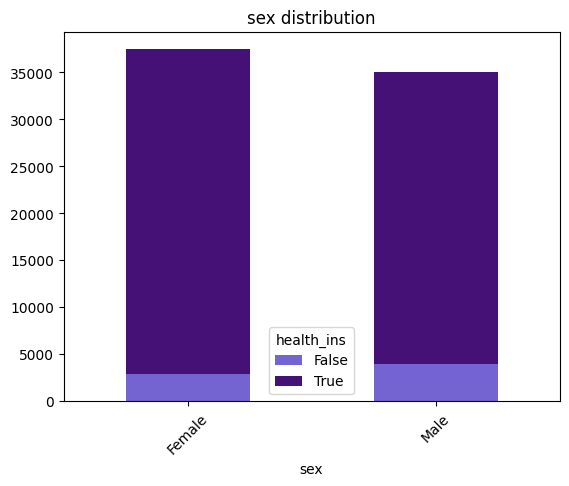

In [135]:
utils.plot_dist(feature='sex')

#### **2.3.3. Age**

For the age feature, we observe that some individuals are listed as 120 years old, which is clearly unrealistic. This suggests the need for preprocessing to handle such anomalies.

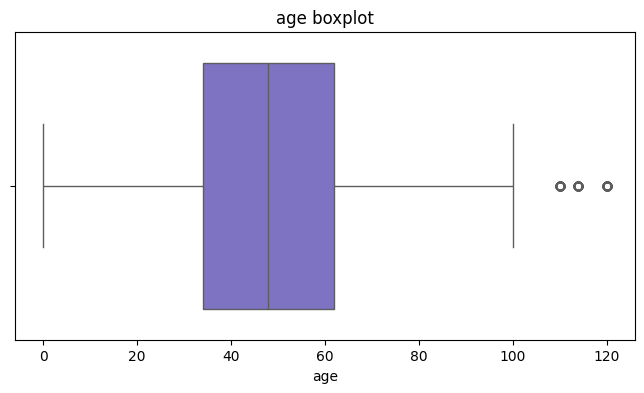

In [136]:
utils.plot_stats('age')

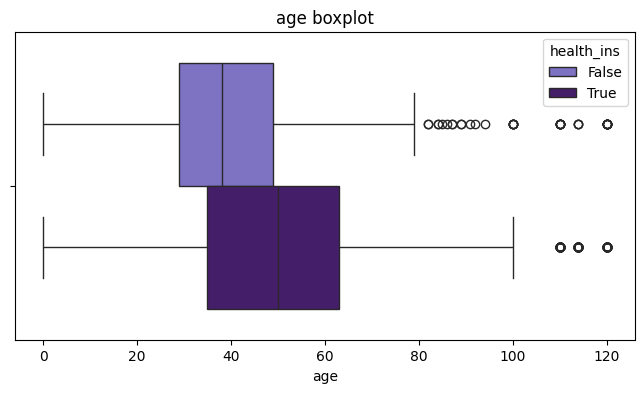

In [137]:
utils.plot_stats('age', with_target_value=True)

Most of the customers are young or early 40s, between 18 and 45 years old.

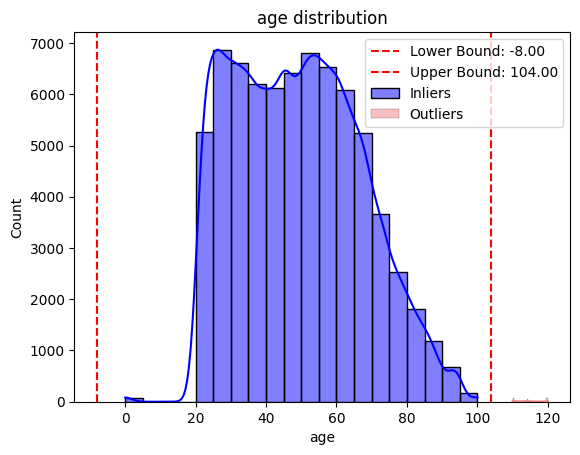

In [138]:
utils.plot_numeric_dist('age')

#### **2.3.4. Income**

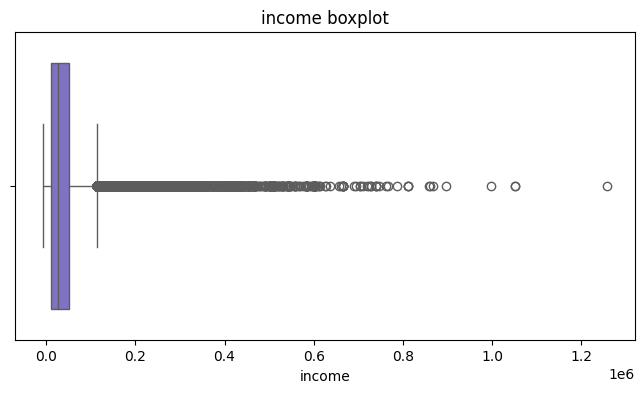

In [139]:
utils.plot_stats('income')

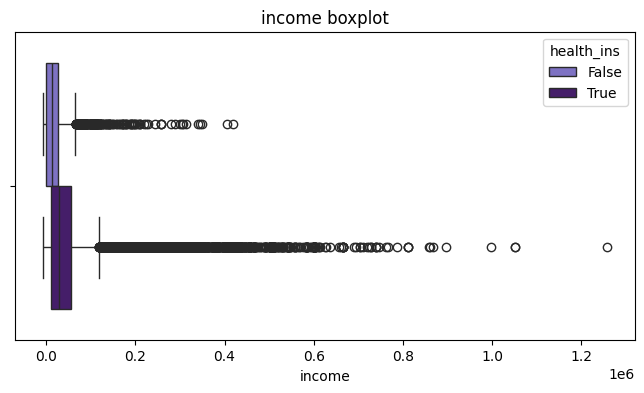

In [140]:
utils.plot_stats('income', with_target_value=True)

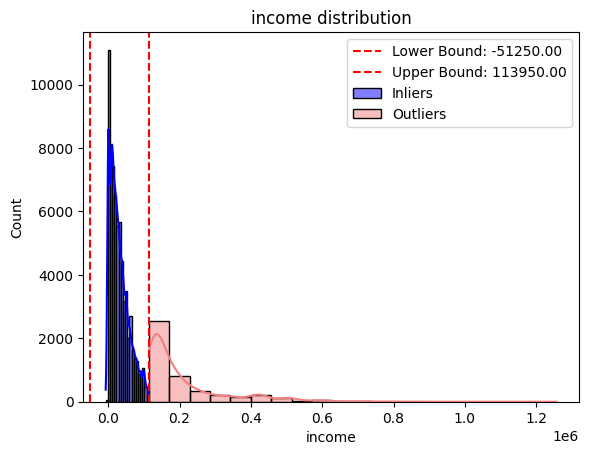

In [141]:
utils.plot_numeric_dist('income')

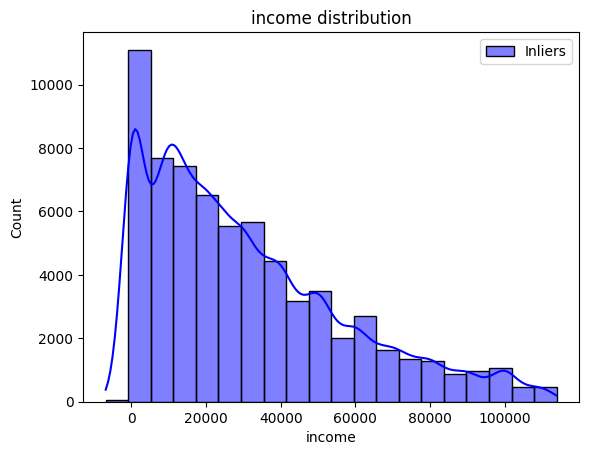

In [142]:
utils.plot_numeric_dist('income', plot_outliers=False)

#### **2.3.5. State of residence**

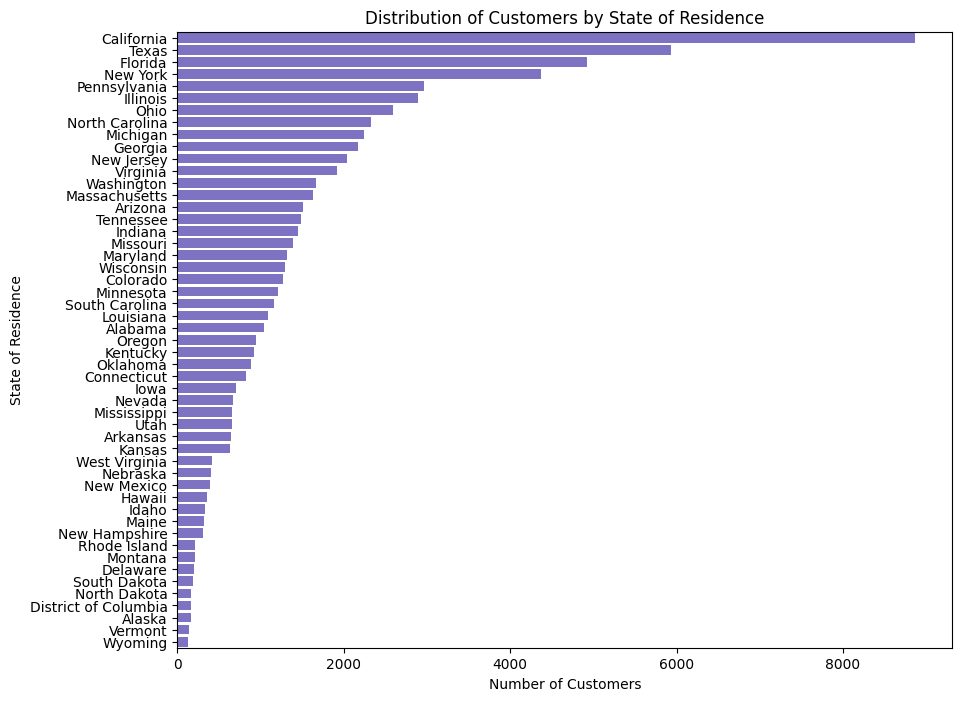

In [143]:
plt.figure(figsize=(10, 8))
sns.countplot(y='state_of_res', data=df, order=df['state_of_res'].value_counts().index)
plt.title('Distribution of Customers by State of Residence')
plt.xlabel('Number of Customers')
plt.ylabel('State of Residence')
plt.show()

The attributes **state_of_res** and **code_column** are directly related, as each state has a unique code. This suggests that one of these features should be dropped to avoid redundancy.

In [144]:
states_with_multiple_codes = df.groupby('state_of_res')['code_column'].nunique()
states_with_multiple_codes = states_with_multiple_codes[states_with_multiple_codes > 1]

print(states_with_multiple_codes)

Series([], Name: code_column, dtype: int64)


#### **2.3.6. Income by age group**

##### **➜ Scatterplot**

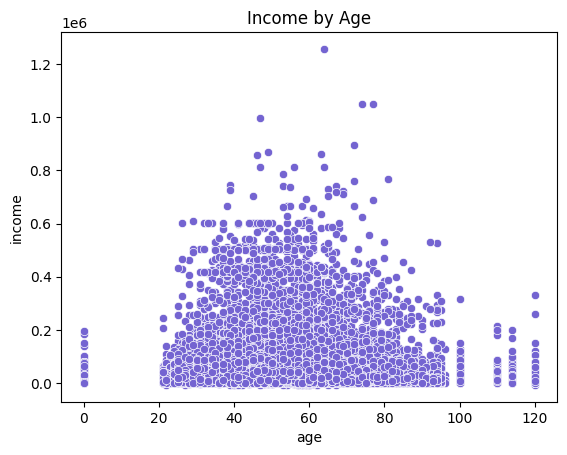

In [145]:
sns.scatterplot(x='age', y='income', data=df)
plt.title('Income by Age')
plt.show()

##### **➜ Boxplot**

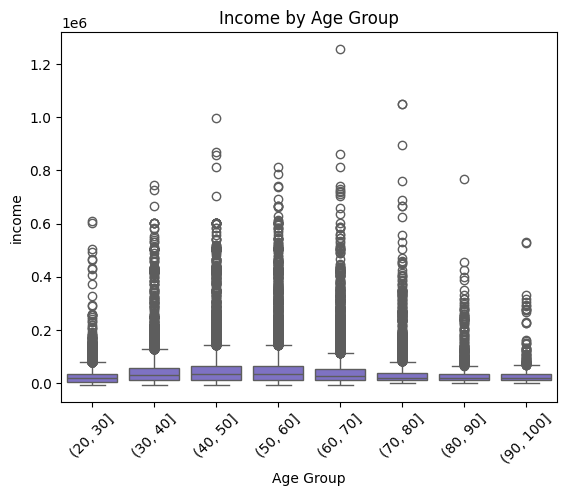

In [146]:
sns.boxplot(x=pd.cut(df['age'], bins=[20, 30, 40, 50, 60, 70, 80, 90, 100]), y='income', data=df)
plt.title('Income by Age Group')
plt.xlabel('Age Group')
plt.xticks(rotation=45)
plt.show()

#### **2.3.7. Probability of health insurance by age**

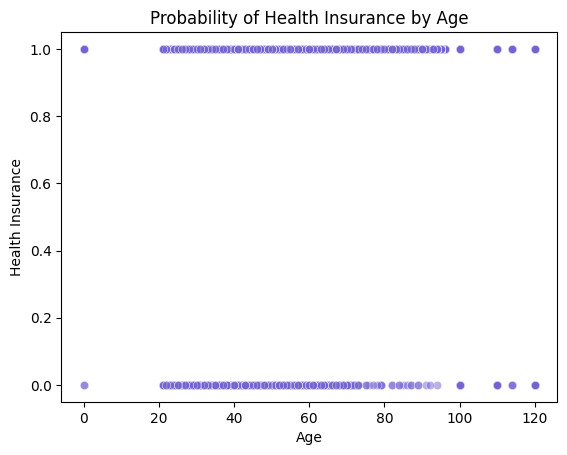

In [147]:
sns.scatterplot(x='age', y='health_ins', data=df, alpha=0.5)
plt.title('Probability of Health Insurance by Age')
plt.xlabel('Age')
plt.ylabel('Health Insurance')
plt.show()

#### **2.3.8. Marital status by housing type**

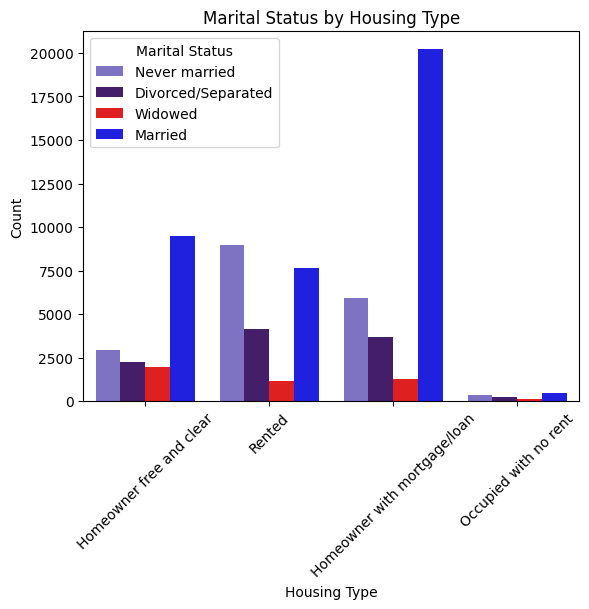

In [148]:
sns.countplot(x='housing_type', hue='marital_status', data=df)
plt.title('Marital Status by Housing Type')
plt.xlabel('Housing Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Marital Status')
plt.show()

#### **2.3.9. Health insurance by marital status**

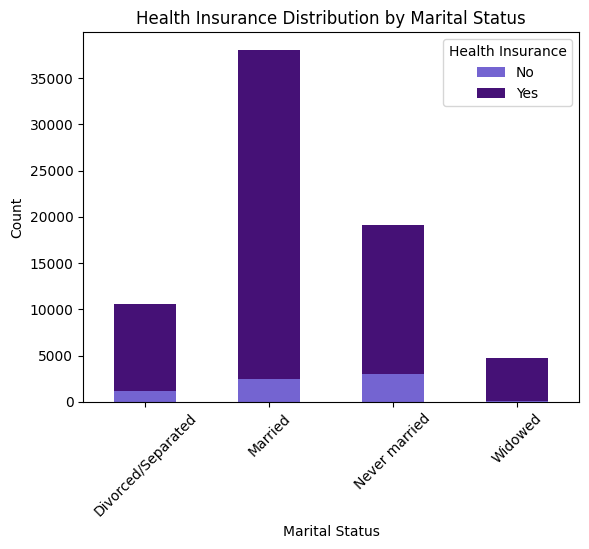

In [149]:
pd.crosstab(df['marital_status'], df['health_ins']).plot(kind='bar', stacked=True)
plt.title('Health Insurance Distribution by Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.legend(title='Health Insurance', labels=['No', 'Yes'])
plt.xticks(rotation=45)
plt.show()

#### **2.3.10. Correlation Matrix**

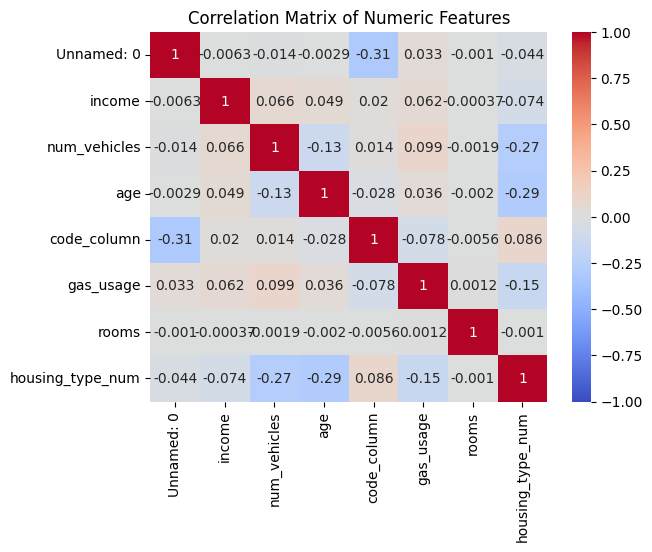

In [150]:
corr_df = df.copy()
corr_df['housing_type_num'] = corr_df['housing_type'].astype('category').cat.codes

correlation_matrix = corr_df.select_dtypes(include=[np.number]).corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

---

## **3. Data Preparation**

After thoroughly understanding the dataset, we identified several aspects that need to be addressed in order to ensure the data is clean and suitable for modeling.

### **3.1. Data Selection**

- **Drop unamed column and Customer ID**: neither variable is necessary to train the models so both can be dropped

- **Highly correlated features: State of Residence and Code Column**: since the code column does not add any information to the state of residence, it can be dropped.

In [151]:
df.drop(columns=['Unnamed: 0', 'custid', 'code_column'], inplace=True)

### **3.2. Data Cleaning**

#### **➜ Handling rows with many missing values:** 

Since some models do not support missing values, rows that have more than two missing values will be dropped for model evaluation.

In [152]:
rows_with_missing = df.isnull().sum(axis=1) > 2
df.drop(df[rows_with_missing].index, inplace=True)

#### **➜ Handling null values** 

- **Is employed:**

In [153]:
df['is_employed'] = df['is_employed'].fillna(False)

C:\Users\Athos\AppData\Local\Temp\ipykernel_17444\1078165704.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['is_employed'] = df['is_employed'].fillna(False)


- **Number of vehicles:**

In order to handle the missing Number of vehicle values, we decided to use the rounded mean value.

In [154]:
df['num_vehicles'] = df['num_vehicles'].fillna(round(df['num_vehicles'].mean(),0))

- **Recent move**

In this case we used the mode since the attribute is categorical and transformed it into a boolean attribute

In [155]:
df['recent_move_b'] = df['recent_move_b'].fillna(df['recent_move_b'].mode()[0])
df['recent_move_b'] = df['recent_move_b'].replace({'T': True, 'F': False})

C:\Users\Athos\AppData\Local\Temp\ipykernel_17444\1087636421.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['recent_move_b'] = df['recent_move_b'].replace({'T': True, 'F': False})


#### **➜ Handling age outliers**

We decided to handle the outliers in the age feature by replacing them with the median value.

In [156]:
Q1 = df['age'].quantile(0.25)
Q3 = df['age'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['age'] < lower_bound) | (df['age'] > upper_bound)]
median_age = df['age'].median()
df['age'] = df['age'].apply(lambda x: median_age if x < lower_bound or x > upper_bound else x)

### **3.3. Data Construction**

#### **➜ Gas Usage and categories**

According to the data dictionary provided, the values of the gas usage attribute include some information beyond the actual monthly billing amount.

In [157]:
def handle_gas_feature(df):
    gas_median = df[df['gas_usage'] > 3].gas_usage.median()

    non_bill_cases_values = {
        1: gas_median,
        2: gas_median,
        3: 0
    }
    non_bill_cases = {
        1: 'Included in rent', 
        2: 'Included in electricity', 
        3: 'No charge'
    }

    # New feature for gas usage category
    df['gas_category'] = df['gas_usage'].replace(non_bill_cases).where(
        df['gas_usage'].isin(non_bill_cases.keys()), 'Actual Bill'
    )
    df.loc[pd.isna(df['gas_usage']), 'gas_category'] = 'Unknown'

    # Replace non-bill cases' values or maintain if not included
    df['gas_usage'] = df['gas_usage'].replace(non_bill_cases_values)
    df['gas_usage'] = df['gas_usage'].fillna(gas_median)

    iqr = df['gas_usage'].quantile(0.75) - df['gas_usage'].quantile(0.25)
    lower_bound = df['gas_usage'].quantile(0.25) - 1.5 * iqr
    upper_bound = df['gas_usage'].quantile(0.75) + 1.5 * iqr

    df.loc[df['gas_usage'] < lower_bound, 'gas_usage'] = lower_bound
    df.loc[df['gas_usage'] > upper_bound, 'gas_usage'] = upper_bound

    df['gas_income'] = df['gas_usage'] * df['income']

In [158]:
handle_gas_feature(df)

#### **➜ Age x Income**

The relationship between Age and Income is important to explore, as it can reveal trends or patterns that may influence the prediction of health insurance status.

In [159]:
df['age_income'] = df.age * df.income

### **3.4. Data Formatting**

This task consisted of choosing the most appropriate transformations for each type of  feature to be applied before training the classifier models.

In [160]:
label_features = ['state_of_res']
categorical_features = ['sex','marital_status', 'housing_type', 'gas_category', 'recent_move_b', 'is_employed', 'health_ins'] 
numerical_features = ['income', 'num_vehicles', 'age', 'gas_usage', 'rooms', 'age_income', 'gas_income']  

features = label_features + categorical_features + numerical_features

preprocessor = ColumnTransformer(
    transformers=[
        ('label', OrdinalEncoder(), label_features),
        ('onehot', OneHotEncoder(drop='first'), categorical_features),
        ('scaler', StandardScaler(), numerical_features)        
    ],
    remainder='passthrough'
)

For our models, we decided to use one hot encoding for the categorical features except state of residency, as that would create 50 additional columns on the dataframe.

#### **3.4.1 Sampling**

We chose to use some sampling techniques to handle the class imbalance issue. By applying these techniques, our models achieve more consistent results and are able to generalize to both classes instead of focusing on the majority class.

##### **➜ Smote**

In [161]:
def smote_data(X, y):
    smote = ADASYN(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

##### **➜ Random Oversampling**

In [162]:
def oversample_data(X, y):
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X, y)
    return X_resampled, y_resampled

##### **➜ Undersampling**

In [163]:
def undersample_data(X, y):
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X, y)
    return X_resampled, y_resampled

### **3.5. Data Description**

#### **➜ Visualization of features after transformation**

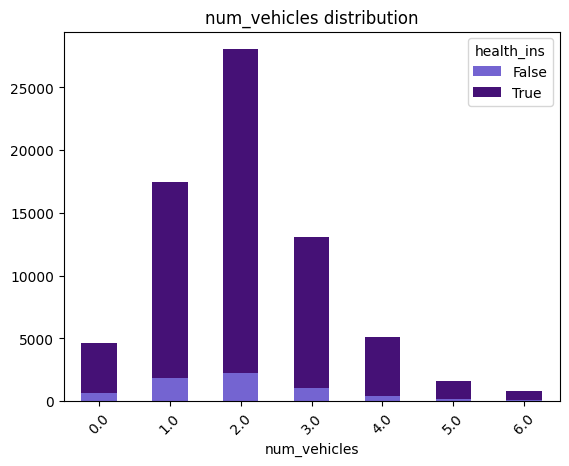

In [164]:
utils.plot_dist('num_vehicles')

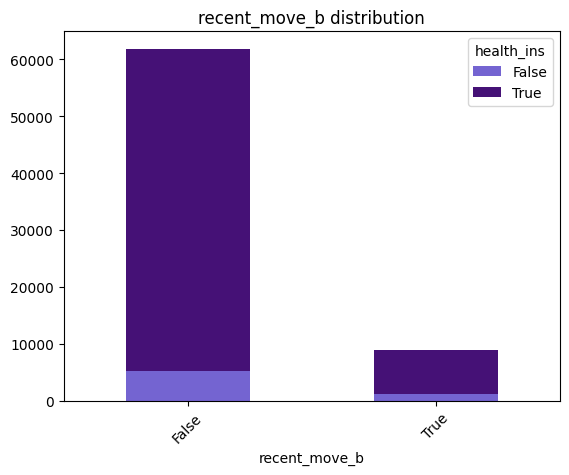

In [165]:
utils.plot_dist('recent_move_b')

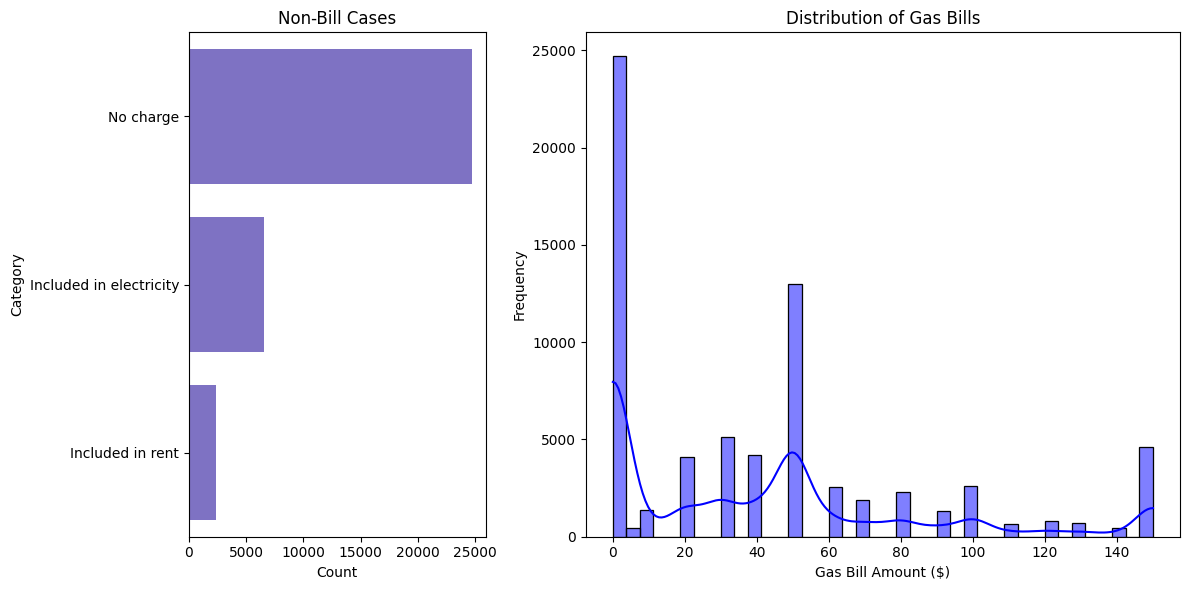

In [166]:
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [1, 2]})

# Bar chart for non-bill cases
non_bills = df[df['gas_category'] != 'Actual Bill']
non_bill_counts = non_bills['gas_category'].value_counts()
sns.barplot(x=non_bill_counts.values, y=non_bill_counts.index, ax=axes[0])
axes[0].set_title('Non-Bill Cases')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Category')

# Histogram for actual bills
sns.histplot(df['gas_usage'], bins=40, kde=True, ax=axes[1], color='blue')
axes[1].set_title('Distribution of Gas Bills')
axes[1].set_xlabel('Gas Bill Amount ($)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

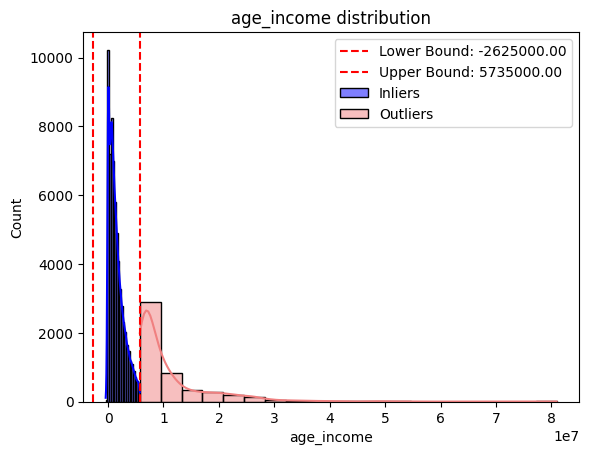

In [167]:
utils.update_df(df)
utils.plot_numeric_dist('age_income')

## **4. Modelling**

First, we defined some helper functions to make the model evaluation less repetitive.

In [168]:
def determine_income_housing(row):
    if row['housing_type_Homeowner with mortgage/loan'] == 1:
        return 1
    elif row['housing_type_Occupied with no rent'] == 1:
        return 0.8
    return 0.6

def preprocess_dataframe(df, _preprocessor):
    _df = df.copy()
    
    x_processed = _preprocessor.fit_transform(_df)

    feature_names = label_features + _preprocessor.named_transformers_['onehot'].get_feature_names_out(categorical_features).tolist() + numerical_features
    feature_names = [name.replace('health_ins_True', 'health_ins') for name in feature_names]
        
    df_processed = pd.DataFrame(x_processed, columns=feature_names)
    df_processed['income_state'] = df_processed['income'] * df_processed['state_of_res']
    df_processed['income_housing'] = df_processed['income'] * df_processed.apply(determine_income_housing, axis=1)
    
    return df_processed

These functions apply the preprocessing steps for the training datasets.


In [169]:
def classify_split_then_sample(df, preprocessor, sample_function, params, classifier):
    
    # Preprocess data
    preprocessed_df = preprocess_dataframe(df, preprocessor)

    X = preprocessed_df.drop(columns='health_ins')  
    y = preprocessed_df['health_ins']
        
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Sample data
    X_resampled, y_resampled = sample_function(X_train, y_train)
    
    # Train model with GridSearchCV
    grid_search = GridSearchCV(estimator=classifier, param_grid=params, cv=10)
    
    grid_search.fit(X_resampled, y_resampled)
    
    # Predict
    y_pred = grid_search.predict(X_test)
    
    # Evaluate
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    print(f'F1 Score: {f1}')
    print(f'Accuracy: {accuracy}')
    print(f'Best Parameters: {grid_search.best_params_}')
    print(report)
    
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.title('Confusion Matrix')
    plt.show()

In [170]:
def classify_sample_then_split(df, preprocessor, sample_function, params, classifier):
    
    # Preprocess data
    preprocessed_df = preprocess_dataframe(df, preprocessor)
    
    X = preprocessed_df.drop(columns='health_ins')  
    y = preprocessed_df['health_ins']
        
    # Sample data
    X_resampled, y_resampled = sample_function(X, y)
    
    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
    
    # Train model with GridSearchCV
    grid_search = GridSearchCV(estimator=classifier, param_grid=params, cv=10)
    grid_search.fit(X_train, y_train)
    
    # Predict
    y_pred = grid_search.predict(X_test)
    
    # Evaluate
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    print(f'F1 Score: {f1}')
    print(f'Accuracy: {accuracy}')
    print(f'Best Parameters: {grid_search.best_params_}')
    print(report)
    
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.title('Confusion Matrix')
    plt.show()

These functions apply the sampling techniques and the training process using grid search to obtain the best hyperparameters while also performing cross validation. They display the evaluation scores and confusion matrix. The first one applies the sampling technique after doing the train-test split while the second one applies it before splitting.

#### **4.1. K-Nearest Neightbour**

In [171]:
KNN_params = {
    'n_neighbors': [1, 3, 5, 7]
}

F1 Score: 0.9466377440347071
Accuracy: 0.9490208268573205
Best Parameters: {'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95     19191
         1.0       1.00      0.90      0.95     19413

    accuracy                           0.95     38604
   macro avg       0.95      0.95      0.95     38604
weighted avg       0.95      0.95      0.95     38604



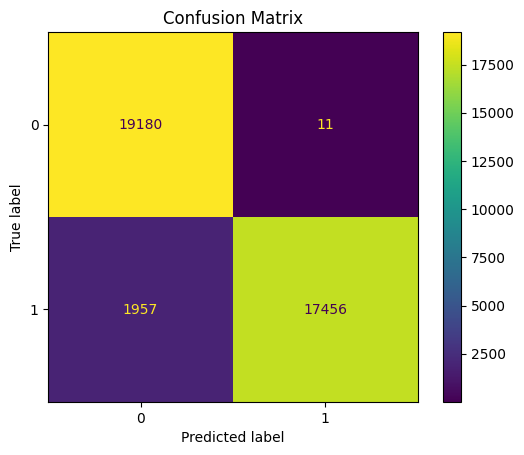

In [172]:
classify_sample_then_split(df, preprocessor, oversample_data, KNN_params, KNeighborsClassifier())

The best results for KNN were achieve using oversampling. This could be due to the fact that oversampling creates new `health_ins=False` entries that are similar to ones that already exist.

#### **4.2. Gaussian Naive Bayes**

In [173]:
gnb_params = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

F1 Score: 0.5102341810856506
Accuracy: 0.6468497911965346
Best Parameters: {'var_smoothing': 1.873817422860383e-05}
              precision    recall  f1-score   support

         0.0       0.59      0.93      0.72     19149
         1.0       0.84      0.37      0.51     19404

    accuracy                           0.65     38553
   macro avg       0.72      0.65      0.62     38553
weighted avg       0.72      0.65      0.62     38553



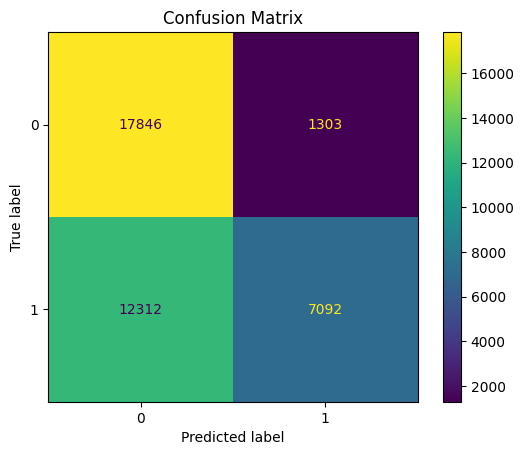

In [174]:
classify_sample_then_split(df, preprocessor, smote_data, gnb_params, GaussianNB())

#### **4.3. Decision Tree**

In [175]:
tree_params = {
    'max_depth': [29],
    'criterion': ['gini'],
    'splitter': ['random'],
    'class_weight': ['balanced']
}

F1 Score: 0.8936921957809415
Accuracy: 0.893860399968874
Best Parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 29, 'splitter': 'random'}
              precision    recall  f1-score   support

         0.0       0.89      0.90      0.89     19149
         1.0       0.90      0.89      0.89     19404

    accuracy                           0.89     38553
   macro avg       0.89      0.89      0.89     38553
weighted avg       0.89      0.89      0.89     38553



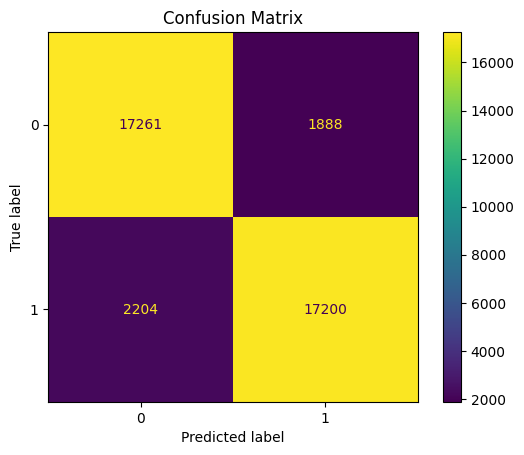

In [176]:
classify_sample_then_split(df, preprocessor, smote_data, tree_params, DecisionTreeClassifier())

#### **4.4. Random Forest**

In [177]:
rf_params = {
    'class_weight': ['balanced'],  
    'criterion': ['gini', 'entropy'],  
    'max_depth': [7, 9],   
    'min_samples_leaf': [1, 2],
    'n_estimators': [200, 300],
    'random_state': [42],
    'bootstrap': [True],
}

In [178]:
classify_sample_then_split(df, preprocessor, smote_data, rf_params, RandomForestClassifier())

KeyboardInterrupt: 

#### **4.5. SVM** 

In [248]:
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf'],
    'gamma': [0.1],
    'class_weight': ['balanced'],
    'probability': [True]
}

F1 Score: 0.8027631339756408
Accuracy: 0.6931127139018526
Best Parameters: {'C': 1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf', 'probability': True}
              precision    recall  f1-score   support

         0.0       0.19      0.76      0.31      1910
         1.0       0.97      0.69      0.80     19303

    accuracy                           0.69     21213
   macro avg       0.58      0.72      0.56     21213
weighted avg       0.90      0.69      0.76     21213



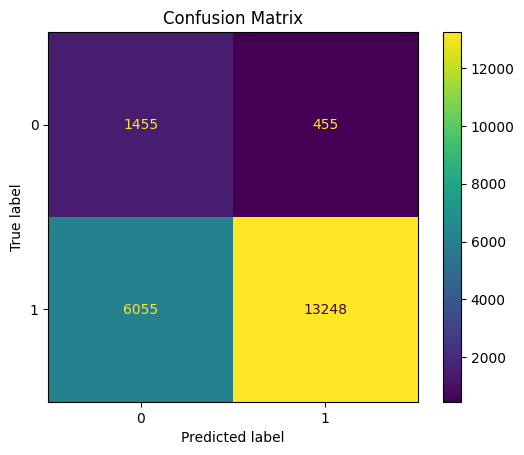

In [249]:
from sklearn.svm import SVC

classify_split_then_sample(df, preprocessor, undersample_data, svm_params, SVC())

Since this classifier is very computationally intensive, we applied undersampling to ensure the training dataset is smaller and balanced.

#### **4.6. Neural Network**

In [ ]:
def create_nn_model():
    nn = Sequential()
    nn.add(layers.Dense(128, activation='relu', input_dim=23)) 
    nn.add(layers.Dense(64, activation='relu'))
    nn.add(layers.Dense(32, activation='relu'))
    nn.add(layers.Dense(1, activation='sigmoid')) 

    nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return nn

In [ ]:
def classify_sample_then_split_nn(df,preprocessor,sample_data,nn):
    # Preprocess data
    preprocessed_df = preprocess_dataframe(df, preprocessor)

    X = preprocessed_df.drop(columns='health_ins')  
    y = preprocessed_df['health_ins']
        
    # Sample data
    X_resampled, y_resampled = sample_data(X, y)
    
    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
    
    # Train model
    nn.fit(X_train, y_train, epochs=30, batch_size=32)
    
    # Predict
    y_pred = nn.predict(X_test)
    y_pred = (y_pred > 0.5)
    
    # Evaluate
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    print(f'F1 Score: {f1}')
    print(f'Accuracy: {accuracy}')
    print(report)
    
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.title('Confusion Matrix')
    plt.show()

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 3s 697us/step - accuracy: 0.7018 - loss: 0.5796
Epoch 2/30
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 2s 674us/step - accuracy: 0.7443 - loss: 0.5167
Epoch 3/30
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 2s 682us/step - accuracy: 0.7522 - loss: 0.5003
Epoch 4/30
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 2s 678us/step - accuracy: 0.7652 - loss: 0.4813
Epoch 5/30
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 2s 679us/step - accuracy: 0.7882 - loss: 0.4445
Epoch 6/30
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 2s 669us/step - accuracy: 0.8046 - loss: 0.4104
Epoch 7/30
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 2s 671us/step - accuracy: 0.8210 - loss: 0.3760
Epoch 8/30
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 2s 674us/step - accuracy: 0.8298 - loss: 0.3581
Epoch 9/30
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 2s 667us/step - accuracy: 0.8407 - loss: 0.3368
Epoch 10/30
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 2s 670us/step - accuracy: 0.8454 - loss: 0.3257
Epoch 11/30
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 2s 681us/step - accuracy: 0.8496 - loss: 0.3156
Epoch 12

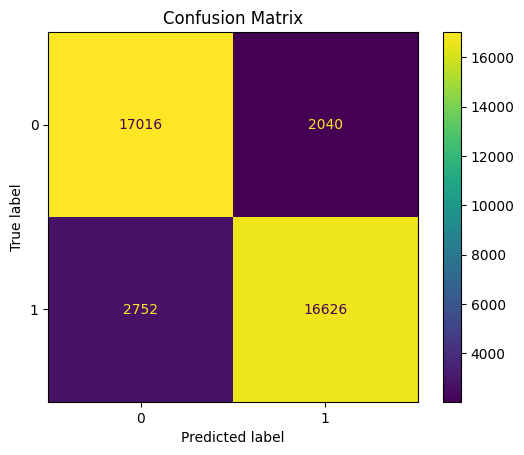

In [ ]:
nn = create_nn_model()

classify_sample_then_split_nn(df, preprocessor, smote_data, nn)

K.clear_session()

#### **4.7. XGBoost**

In [263]:
xgb_params = {
    'max_depth': [7, 9],
    'learning_rate': [0.1, 0.2],
    'n_estimators': [200, 300]
}

In [264]:
def classify_sample_then_split_xgb():
    # Preprocess data
    preprocessed_df = preprocess_dataframe(df, preprocessor)

    X = preprocessed_df.drop(columns='health_ins')  
    y = preprocessed_df['health_ins']

    # Sample data
    X_resampled, y_resampled = smote_data(X, y)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

    # Define the XGBoost classifier and parameter grid
    xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss') 

    # Train model with GridSearchCV
    grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=xgb_params, cv=10, scoring='f1', n_jobs=-1)

    grid_search.fit(X_train, y_train)

    # Predict
    y_pred = grid_search.predict(X_test)

    # Evaluate
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f'F1 Score: {f1}')
    print(f'Accuracy: {accuracy}')
    print(f'Best Parameters: {grid_search.best_params_}')
    print(report)

    # Plot confusion matrix
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.title('Confusion Matrix')
    plt.show()

c:\Users\Athos\anaconda3\envs\ICD\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:58:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.9374093765103915
Accuracy: 0.9326099966174902
Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 200, 'scale_pos_weight': 2, 'subsample': 0.8}
              precision    recall  f1-score   support

         0.0       1.00      0.86      0.93     19025
         1.0       0.88      1.00      0.94     19408

    accuracy                           0.93     38433
   macro avg       0.94      0.93      0.93     38433
weighted avg       0.94      0.93      0.93     38433



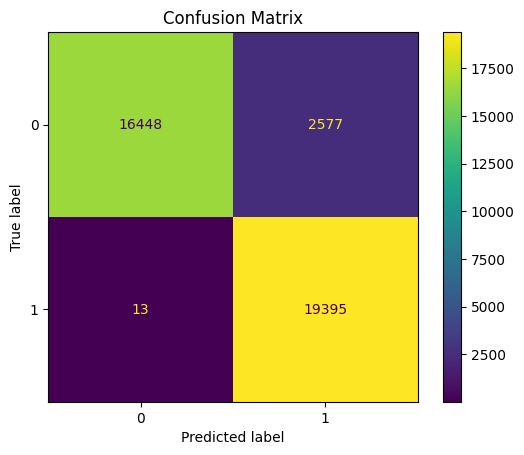

In [265]:
classify_sample_then_split_xgb()

## **6. Submission**

This section corresponds to the methods used to make the submissions to kaggle. It includes training the models with the best parameters we found in the previous section and using them to predict the values on the masked dataset. 

### **6.1. Preprocessing**

In [179]:
raw_data = pd.read_csv('customer.csv')
masked_df = pd.read_csv('customer_test_masked.csv')

In [180]:
label_features = ['state_of_res']
categorical_features = ['sex', 'marital_status', 'housing_type', 'gas_category', 'recent_move_b', 'is_employed']
numerical_features = ['income', 'num_vehicles', 'age', 'gas_usage', 'rooms', 'age_income']
target_feature = 'health_ins'
id_feature = 'custid'

# Define a preprocessor globally so it can be reused
preprocessor = ColumnTransformer(
    transformers=[
        ('label', OrdinalEncoder(), label_features),
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features),
        ('scaler', StandardScaler(), numerical_features)
    ],
    remainder='passthrough'
)

def preprocess_dataframe(df, fit_preprocessor=True):
    global preprocessor  # Use the same preprocessor instance
    
    # Drop the target feature for feature processing
    df_features = df.drop(target_feature, axis=1, errors='ignore')
    
    if fit_preprocessor:
        # Fit and transform the preprocessor on training data
        features_processed = preprocessor.fit_transform(df_features)
    else:
        # Only transform using an already fitted preprocessor
        features_processed = preprocessor.transform(df_features)
    
    # Extract feature names from the preprocessor
    feature_names = (
        label_features +
        preprocessor.named_transformers_['onehot'].get_feature_names_out(categorical_features).tolist() +
        numerical_features +
        [id_feature]
    )
    
    # Create a DataFrame for the processed features
    df_processed = pd.DataFrame(features_processed, columns=feature_names)
    
    # Ensure indices align
    df_processed = df_processed.reset_index(drop=True)
    
    # Add the target feature back if it exists in the original DataFrame
    if target_feature in df.columns:
        df_target = df[target_feature].reset_index(drop=True)
        df_processed[target_feature] = df_target
    
    return df_processed

In [181]:
def handle_gas_feature(df):
    
    df_copy = df.copy()
    
    gas_median = df_copy[df_copy['gas_usage'] > 3].gas_usage.median()

    non_bill_cases_values = {
        1: gas_median,
        2: gas_median,
        3: 0
    }
    non_bill_cases = {
        1: 'Included in rent', 
        2: 'Included in electricity', 
        3: 'No charge'
    }

    # New feature for gas usage category
    df_copy['gas_category'] = df_copy['gas_usage'].replace(non_bill_cases).where(
        df_copy['gas_usage'].isin(non_bill_cases.keys()), 'Actual Bill'
    )
    df_copy.loc[pd.isna(df_copy['gas_usage']), 'gas_category'] = 'Unknown'

    # Replace non-bill cases' values or maintain if not included
    df_copy['gas_usage'] = df_copy['gas_usage'].replace(non_bill_cases_values)
    df_copy['gas_usage'] = df_copy['gas_usage'].fillna(gas_median)
    
    return df_copy

In [182]:
def apply_data_engineering_replace(df):
    
    df_replaced = df.copy()
    
    df_replaced.drop(columns=['Unnamed: 0', 'code_column'], inplace=True)

    df_replaced['housing_type'] = df_replaced['housing_type'].fillna(df_replaced['housing_type'].mode()[0])
    
    df_replaced['is_employed'] = df_replaced['is_employed'].fillna(False)
    
    df_replaced['num_vehicles'] = df_replaced['num_vehicles'].fillna(round(df['num_vehicles'].mean(),0))
    
    df_replaced['recent_move_b'] = df_replaced['recent_move_b'].fillna(df_replaced['recent_move_b'].mode()[0])
    df_replaced['recent_move_b'] = df_replaced['recent_move_b'].replace({'T': True, 'F': False})
    
    Q1 = df['age'].quantile(0.25)
    Q3 = df['age'].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    median_age = df['age'].median()
    df['age'] = df['age'].apply(lambda x: median_age if x < lower_bound or x > upper_bound else x)
    
    df_replaced = handle_gas_feature(df_replaced)
    
    df_replaced['age_income'] = df_replaced.age * df_replaced.income
    
    return df_replaced

### **6.2 XGBoost**

In [183]:
def apply_data_engineering_xgb(df):
    df_filtered = df.copy()
    
    df_filtered.drop(columns=['Unnamed: 0'], inplace=True)

    # Replace age = 0 and age = 120 with NaN
    df_filtered['age'] = df_filtered['age'].replace([0, 120], np.nan)

    # Handle the gas feature
    handle_gas_feature(df_filtered)

    # Create a new feature: age_income, ensuring NaN handling explicitly
    df_filtered['age_income'] = np.where(df_filtered['age'].isna(), np.nan, df_filtered['age'] * df_filtered['income'])


    return df_filtered

In [184]:
def convert_feature_types(df):
    for col in df.select_dtypes(include=['object']).columns:
        if col in categorical_features or col in label_features:
            df[col] = df[col].astype('category')
        elif col in numerical_features:
            df[col] = df[col].astype('float')

In [185]:
xgb_train_df = apply_data_engineering_xgb(raw_data)
xgb_sub_df = apply_data_engineering_xgb(masked_df)

convert_feature_types(xgb_train_df)
convert_feature_types(xgb_sub_df)

In [186]:
# Separate features and target
X = xgb_train_df.drop([target_feature, id_feature], axis=1)
y = xgb_train_df[target_feature]


# Prepare XGBoost DMatrix
dtrain = xgb.DMatrix(X, label=y, enable_categorical=True)

# Define model parameters
params = {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 200, 'scale_pos_weight': 2, 'subsample': 0.8}

num_rounds = 100

# Train the model
bst = xgb.train(params, dtrain, num_rounds)

# Prepare the submission data
sub = xgb_sub_df.drop([target_feature, id_feature], axis=1)
dsubmission = xgb.DMatrix(sub, enable_categorical=True)

# Predict probabilities and convert to binary predictions
preds = bst.predict(dsubmission)
y_pred = [True if pred > 0.9 else False for pred in preds]

# Create a DataFrame for predictions and 'custid'
xgb_submission_df = pd.DataFrame({
    'custid': masked_df['custid'],  # Retrieve the 'custid' column
    'health_ins': y_pred                     # Add predicted values
})

# Store the results without column names in CSV format
xgb_submission_df.to_csv('submissions/xgb_submission.csv', index=False)

c:\Users\Athos\anaconda3\envs\ICD\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:41:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


### **6.3. Random Forest**

In [187]:
rf_train_data = apply_data_engineering_replace(raw_data)
rf_submission_data = apply_data_engineering_replace(masked_df)

rf_train_data = preprocess_dataframe(rf_train_data, fit_preprocessor=True)
rf_submission_data = preprocess_dataframe(rf_submission_data, fit_preprocessor=False)
rf_submission_data['health_ins'] = rf_submission_data['health_ins'].astype(bool)

C:\Users\Athos\AppData\Local\Temp\ipykernel_17444\3109259970.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_replaced['is_employed'] = df_replaced['is_employed'].fillna(False)
C:\Users\Athos\AppData\Local\Temp\ipykernel_17444\3109259970.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_replaced['recent_move_b'] = df_replaced['recent_move_b'].replace({'T': True, 'F': False})
C:\Users\Athos\AppData\Local\Temp\ipykernel_17444\3109259970.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and

In [188]:
# separate features
X = rf_train_data.drop([target_feature, id_feature], axis=1)
y = rf_train_data[target_feature]

# define model random forest model following the best parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 20, 'n_estimators': 300}
rf_model = RandomForestClassifier(class_weight='balanced', criterion='gini', max_depth=20, n_estimators=300)

# resample data
X_resampled, y_resampled = smote_data(X, y)

# fit model
rf_model.fit(X_resampled, y_resampled)

rf_submission_features = rf_submission_data.drop(columns=[target_feature, id_feature])

# predict
y_pred = rf_model.predict(rf_submission_features)

# Create a DataFrame for the predictions and the custid
rf_submission_df = pd.DataFrame({
    'custid': rf_submission_data['custid'],  # Retrieve the 'custid' column from the original DataFrame
    'health_ins': y_pred           # Add the predicted values
})

# Store the DataFrame without column names
rf_submission_df.to_csv('submissions/rf_submission.csv', index=False)



### **6.4. Decision Tree**

In [189]:
dt_train_data = apply_data_engineering_replace(raw_data)
dt_submission_data = apply_data_engineering_replace(masked_df)

dt_train_data = preprocess_dataframe(dt_train_data, fit_preprocessor=True)
dt_submission_data = preprocess_dataframe(dt_submission_data, fit_preprocessor=False)
dt_submission_data['health_ins'] = dt_submission_data['health_ins'].astype(bool)

C:\Users\Athos\AppData\Local\Temp\ipykernel_17444\3109259970.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_replaced['is_employed'] = df_replaced['is_employed'].fillna(False)
C:\Users\Athos\AppData\Local\Temp\ipykernel_17444\3109259970.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_replaced['recent_move_b'] = df_replaced['recent_move_b'].replace({'T': True, 'F': False})
C:\Users\Athos\AppData\Local\Temp\ipykernel_17444\3109259970.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and

In [190]:
# separate features
X = dt_train_data.drop([target_feature, id_feature], axis=1)
y = dt_train_data[target_feature]

# define model random forest model following the best parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 29, 'splitter': 'best'}
dt_model = DecisionTreeClassifier(class_weight='balanced', criterion='entropy', max_depth=28, splitter='best')

# resample data
X_resampled, y_resampled = smote_data(X, y)

# fit model
dt_model.fit(X_resampled, y_resampled)

dt_submission_features = dt_submission_data.drop(columns=[target_feature, id_feature])

# predict
y_pred = dt_model.predict(dt_submission_features)

# Create a DataFrame for the predictions and the custid
dt_submission_df = pd.DataFrame({
    'custid': dt_submission_data['custid'],  # Retrieve the 'custid' column from the original DataFrame
    'health_ins': y_pred           # Add the predicted values
})

# Store the DataFrame without column names
dt_submission_df.to_csv('submissions/dt_submission.csv', index=False)

### **6.5. SVM**

In [191]:
svm_train_data = apply_data_engineering_replace(raw_data)
svm_submission_data = apply_data_engineering_replace(masked_df)

svm_train_data = preprocess_dataframe(svm_train_data, fit_preprocessor=True)
svm_submission_data = preprocess_dataframe(svm_submission_data, fit_preprocessor=False)
svm_submission_data['health_ins'] = svm_submission_data['health_ins'].astype(bool)

C:\Users\Athos\AppData\Local\Temp\ipykernel_17444\3109259970.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_replaced['is_employed'] = df_replaced['is_employed'].fillna(False)
C:\Users\Athos\AppData\Local\Temp\ipykernel_17444\3109259970.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_replaced['recent_move_b'] = df_replaced['recent_move_b'].replace({'T': True, 'F': False})
C:\Users\Athos\AppData\Local\Temp\ipykernel_17444\3109259970.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and

In [192]:
from sklearn.svm import SVC

# separate features
X = svm_train_data.drop([target_feature, id_feature], axis=1)
y = svm_train_data[target_feature]

# define model 
svm_model = SVC(C=0.1, kernel='rbf', gamma=0.01, class_weight='balanced')

# resample data
X_resampled, y_resampled = undersample_data(X, y)

# fit model
svm_model.fit(X_resampled, y_resampled)

svm_submission_features = svm_submission_data.drop(columns=[target_feature, id_feature])

# predict
y_pred = svm_model.predict(svm_submission_features)

# Create a DataFrame for the predictions and the custid
svm_submission_df = pd.DataFrame({
    'custid': svm_submission_data['custid'],  # Retrieve the 'custid' column from the original DataFrame
    'health_ins': y_pred           # Add the predicted values
})

# Store the DataFrame without column names
svm_submission_df.to_csv('submissions/svm_submission.csv', index=False)